## Imports

In [1]:
import torch
import pickle
import onnx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import Tensor

from torch.nn import ReLU
from torch.nn import Module
from torch.nn import Linear
from torch.nn import Softmax

from torchinfo import summary

from livelossplot import PlotLosses

from torch.optim import SGD
from torch.optim import Adam

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset

from torch.nn import CrossEntropyLoss

from torch.nn.init import xavier_uniform_
from torch.nn.init import kaiming_uniform_

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torchsampler import ImbalancedDatasetSampler

from sklearn.model_selection import train_test_split

C:\Users\duart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = 'C:/Users/duart/Desktop/SA/model/data.csv'

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

INPUTS = 6
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

cuda


## Preparar os Dados

In [3]:
##  0 - Andar
##  1 - Correr
##  2 - Subir Escadas
##  3 - Descer Escadas
##  4 - Quieto

In [4]:
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path):
        df = pd.read_csv(path)
        # drop de features irrelevantes
        df = df.drop(columns=['I','I__name','I__height','I__timestamp','I__weight','I__lado'], axis=1)

        # split input e output
        self.X = df.values[:, :-1]
        self.y = df.values[:,  -1]

        # garantir que os inputs sejam floats
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
    
    # número de casos no dataset
    def __len__(self):
        return len(self.X)

    # retornar um caso
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # retornar índices para casos de treino e de teste
    def get_splits_strat(self, n_test=0.33):
        train_X, test_X, train_y, test_y = train_test_split(self.X, self.y, 
                                                            test_size=n_test,
                                                            random_state=999,
                                                            shuffle=True,
                                                            stratify=self.y)
        train = TensorDataset(torch.from_numpy(train_X),torch.from_numpy(train_y))
        test = TensorDataset(torch.from_numpy(test_X),torch.from_numpy(test_y))
        return train, test
    
# preparar o dataset
def prepare_data(path):
    dataset = CSVDataset(path)
    train, test = dataset.get_splits_strat()

    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl  = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=True)
    test_dl_all  = DataLoader(test , batch_size=len(test), shuffle=True)

    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados
train_dl, test_dl, train_dl_all, test_dl_all = prepare_data(PATH)

## Visualizar os Dados

In [5]:
def visualize_data(path):
    df = pd.read_csv(path, header=None)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino: {len(train_dl.dataset)}") 
    print(f"Quantidade de casos de  Teste: {len(test_dl.dataset)}" )
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos teste, input: {x.shape}, output: {y.shape}")

visualize_data(PATH)
visualize_dataset(train_dl, test_dl)

C:\Users\duart\AppData\Local\Temp\ipykernel_6588\3632537850.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, header=None)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,I,I__acc__001,I__acc__002,I__acc__003,I__gyros__001,I__gyros__002,I__gyros__003,I__height,I__lado,I__name,I__timestamp,I__weight,I__activity
1,-NSMLLP-WsmCqK_X-G0R,-0.6804589629173279,2.301297187805176,5.4418768882751465,0.1665758192539215,-0.06537867337465286,-0.10732222348451614,185,2,tiago,1680797673482,65,3
2,-NSMLLP1-oDb8tkaK2Hf,-0.6708876490592957,2.2677977085113525,5.370092391967773,0.19214141368865967,-0.06857437640428543,-0.10945269465446472,185,2,tiago,1680797673482,65,3
3,-NSMLLP3P5VTqy_06lcF,-0.6780661344528198,2.303689956665039,5.288437366485596,0.22516362369060516,-0.06644391268491745,-0.10838746279478073,185,2,tiago,1680797673483,65,3
4,-NSMLLP4qCw3fLfesaR1,-0.7139584422111511,2.2773690223693848,5.202295303344727,0.2539249360561371,-0.06750914454460144,-0.10945269465446472,185,2,tiago,1680797673483,65,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267793,-NVTwnaUhsBU-bFWaQp-,-0.287781,5.999268,12.901154,-0.35556,0.047775,-0.143814,172,2,Duda,1684146435127,60,2
267794,-NVTwna_beKTOrRpf2u3,-1.774582,5.824493,10.643417,0.915619,-0.08374,-0.122574,172,2,Duda,1684146435127,60,2
267795,-NVTwnaf4XUKjsYIKnaN,-3.086609,6.145325,8.060074,-1.174423,0.133682,0.683685,172,2,Duda,1684146435140,60,2
267796,-NVTwnaiZuJ-st_fawXw,-3.733047,6.633728,6.159073,-0.073639,-0.021378,0.173157,172,2,Duda,1684146435170,60,2


Quantidade de casos de Treino: 179423
Quantidade de casos de  Teste: 88374
Shape tensor batch casos treino, input: torch.Size([64, 6]), output: torch.Size([64])
Shape tensor batch casos teste, input: torch.Size([64, 6]), output: torch.Size([64])


## Verificar balanceamento do dataset

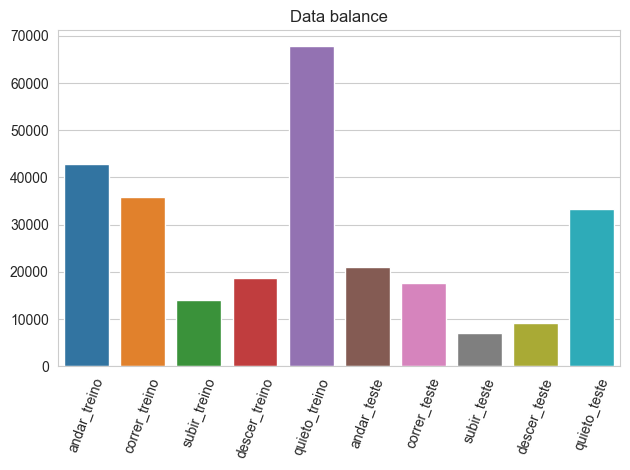

casos_treino:  179423
andar_treino:  42833
correr_treino:  35891
subir_treino:  14135
descer_treino:  18796
quieto_treino:  67768
casos_teste:  88374
andar_teste:  21097
correr_teste:  17678
subir_teste:  6962
descer_teste:  9258
quieto_teste:  33379


In [6]:
def visualize_holdout_balance(y_train, y_test):
    _, y_train = next(iter(train_dl_all))                            
    _, y_test = next(iter(test_dl_all))

    sns.set_style('whitegrid')
    casos_treino = len(y_train)
    casos_test = len(y_test)
    
    andar_Train  = np.count_nonzero(y_train == 0)
    correr_Train = np.count_nonzero(y_train == 1)
    subir_Train  = np.count_nonzero(y_train == 2)
    descer_Train = np.count_nonzero(y_train == 3)
    quieto_Train = np.count_nonzero(y_train == 4)
    andar_Test   = np.count_nonzero(y_test  == 0)
    correr_Test  = np.count_nonzero(y_test  == 1)
    subir_Test   = np.count_nonzero(y_test  == 2)
    descer_Test  = np.count_nonzero(y_test  == 3)
    quieto_Test  = np.count_nonzero(y_test  == 4)

    grafico = sns.barplot(x=['andar_treino','correr_treino', 'subir_treino', 'descer_treino', 'quieto_treino', 'andar_teste', 'correr_teste', 'subir_teste', 'descer_teste', 'quieto_teste'], 
                          y=[andar_Train, correr_Train, subir_Train, descer_Train, quieto_Train, andar_Test, correr_Test, subir_Test, descer_Test, quieto_Test])
    grafico.set_title('Data balance')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

    print("casos_treino: " , casos_treino)
    print("andar_treino: " , andar_Train )
    print("correr_treino: ", correr_Train)
    print("subir_treino: " , subir_Train )
    print("descer_treino: ", descer_Train)
    print("quieto_treino: ", quieto_Train)
    print("casos_teste: "  , casos_test  )
    print("andar_teste: "  , andar_Test  )
    print("correr_teste: " , correr_Test )
    print("subir_teste: "  , subir_Test  )
    print("descer_teste: " , descer_Test )
    print("quieto_teste: " , quieto_Test )
    
visualize_holdout_balance(train_dl_all, test_dl_all)

## Definir o Modelo

In [7]:
class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        
        self.hidden1 = Linear(n_inputs, 128)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu') # He initialization (otimizada para funções de ativação relu)
        self.act1 = ReLU()
        
        self.hidden2 = Linear(128, 64)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()

        self.hidden3 = Linear(64, 32)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        
        self.hidden4 = Linear(32, 5)
        xavier_uniform_(self.hidden4.weight) # Glorot initialization
        self.act4 = Softmax(dim=1)
 
    # sequência de propagação do input 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)

        X = self.hidden2(X)
        X = self.act2(X)
        
        X = self.hidden3(X)
        X = self.act3(X)

        X = self.hidden4(X)
        X = self.act4(X)
        return X
 
# definir a rede neuronal
model = MLP(INPUTS)
# sumário da rede
print(summary(model, input_size=(BATCH_SIZE, INPUTS), verbose=0)) # verbose=2 Show weight and bias layers in full detail
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 5]                   --
├─Linear: 1-1                            [64, 128]                 896
├─ReLU: 1-2                              [64, 128]                 --
├─Linear: 1-3                            [64, 64]                  8,256
├─ReLU: 1-4                              [64, 64]                  --
├─Linear: 1-5                            [64, 32]                  2,080
├─ReLU: 1-6                              [64, 32]                  --
├─Linear: 1-7                            [64, 5]                   165
├─Softmax: 1-8                           [64, 5]                   --
Total params: 11,397
Trainable params: 11,397
Non-trainable params: 0
Total mult-adds (M): 0.73
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.05
Estimated Total Size (MB): 0.16


MLP(
  (hidden1): Linear(in_features=6, out_features=128, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=64, out_features=32, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=32, out_features=5, bias=True)
  (act4): Softmax(dim=1)
)

## Treinar o Modelo

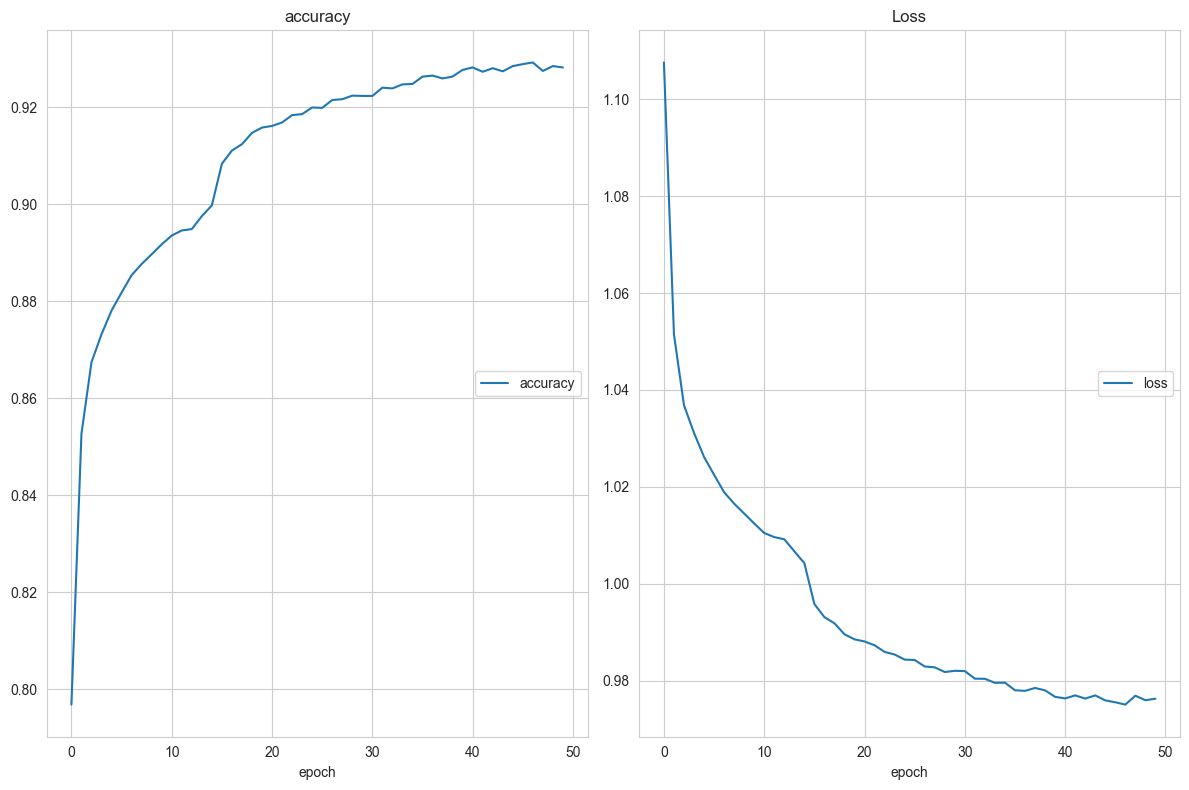

accuracy
	accuracy         	 (min:    0.797, max:    0.929, cur:    0.928)
Loss
	loss             	 (min:    0.975, max:    1.108, cur:    0.976)


In [8]:
def train_model(train_dl, model):
    liveloss = PlotLosses() # visualização do processo de treino
    
    # função de loss
    criterion = CrossEntropyLoss()
    
    # função de otimização
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    # optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) # Stochastic Gradient Descent
    # experimentar com o Adagrad se o modelo se tornar grande e complexo
    
    # iterar as epochs
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0
        epoch_acc  = 0

        # iterar as batchs
        for i, (inputs, labels) in enumerate(train_dl): # backpropagation
            inputs = inputs.to(device)
            labels = labels.to(device)
            # inicializar os gradientes, coloca os gradientes de todos os parametros a zero
            optimizer.zero_grad()
            # calcular o output do modelo - previsao/forward
            outputs = model(inputs)
            # calcular o loss
            loss = criterion(outputs, labels.long())
            # calcular a accuracy
            outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
            acc = accuracy_score(labels.detach().cpu().numpy(), outputs)
            # atribuição alteraçoes "In the backward pass we receive a Tensor containing the gradient of the loss
            # with respect to the output, and we need to compute the gradient of the loss with respect to the input.
            loss.backward() # backpropagation
            # update pesos do modelo
            optimizer.step()
            # calcular epochs de loss e epochs de accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss/len(train_dl)
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()
 
# treinar o modelo
train_model(train_dl, model)

## Avaliar o Modelo

Accuracy: 0.921

real:4.0 previsão:4
real:4.0 previsão:4
real:4.0 previsão:4
real:0.0 previsão:0
real:1.0 previsão:1
real:1.0 previsão:1
real:4.0 previsão:4
real:4.0 previsão:4
real:0.0 previsão:0
real:2.0 previsão:2
real:2.0 previsão:1
real:4.0 previsão:4
real:1.0 previsão:1
real:4.0 previsão:4
real:1.0 previsão:1
real:4.0 previsão:4
real:4.0 previsão:4
real:3.0 previsão:3
real:1.0 previsão:1
real:1.0 previsão:1
real:0.0 previsão:0
real:0.0 previsão:0
real:3.0 previsão:3
real:4.0 previsão:4
real:1.0 previsão:1
real:3.0 previsão:3
real:4.0 previsão:4
real:3.0 previsão:3
real:4.0 previsão:4
real:4.0 previsão:4
real:2.0 previsão:2
real:1.0 previsão:1
real:4.0 previsão:4
real:0.0 previsão:0
real:0.0 previsão:0
real:4.0 previsão:4
real:0.0 previsão:0
real:0.0 previsão:0
real:0.0 previsão:0
real:4.0 previsão:4
real:4.0 previsão:4
real:0.0 previsão:0
real:2.0 previsão:2
real:3.0 previsão:3
real:0.0 previsão:0
real:3.0 previsão:3
real:4.0 previsão:4
real:4.0 previsão:4
real:1.0 previsão:1
rea

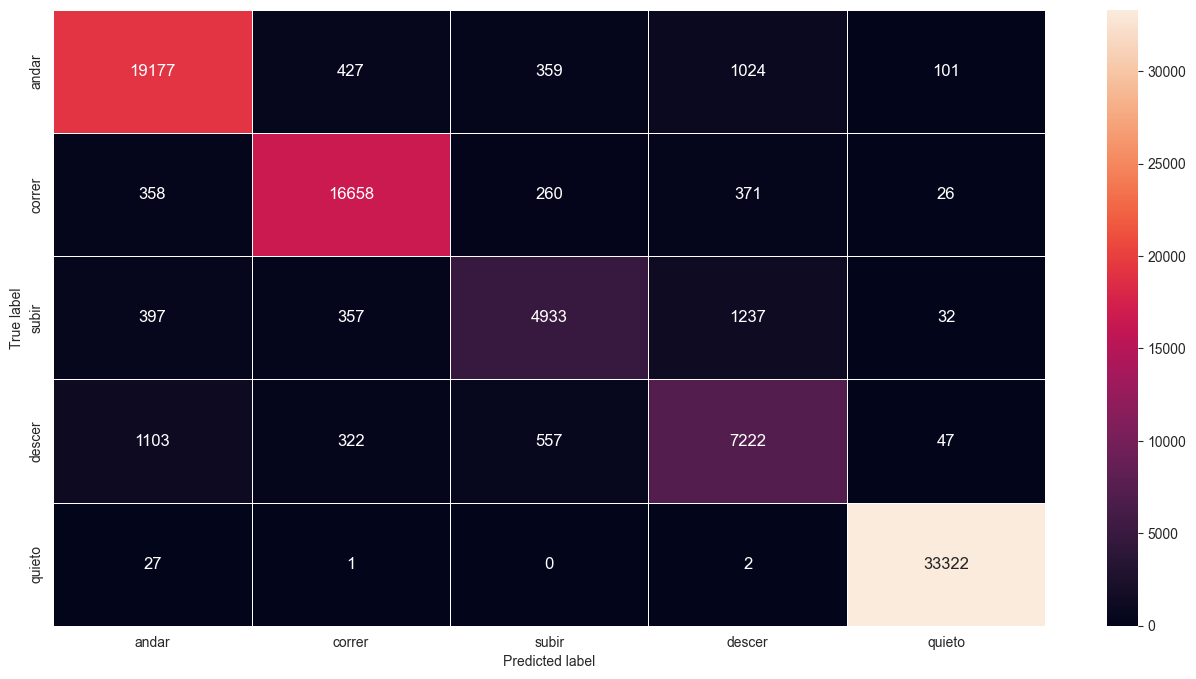

In [9]:
# Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    
    for i, (inputs, labels) in enumerate(test_dl):
        inputs = inputs.to(device)
        # avaliar o modelo com os casos de teste
        yprev = model(inputs)
        # retirar o array numpy
        yprev = np.argmax(yprev.detach().cpu().numpy(), axis=1)
        actual = labels.numpy()
        # arredondar para obter a classe
        #yprev = yprev.round()
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
    
    # arranjar uma melhor solução para isto (basicamente tou a mandar a ultima batch co crlh)
    predictions.pop()
    actual_values.pop()
    predictions = np.vstack(predictions).flatten()
    actual_values = np.vstack(actual_values).flatten()
    return predictions, actual_values

# Matriz de confusão
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm, annot=True, xticklabels=['andar','correr', 'subir', 'descer', 'quieto'], yticklabels=['andar','correr', 'subir', 'descer', 'quieto'], annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
# avaliar o modelo
predictions, actual_values = evaluate_model(test_dl, model)
# calcular a accuracy
acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}') 
    if r==p: acertou+=1  
    else: falhou+=1
print(f'acertou:{acertou} falhou:{falhou}')

# relatório de classificação: precision, recall, f1-score, support vs. 0,1, accuracy, macro avg, weighted avg
print(classification_report(actual_values, predictions))

# matriz confusão
cm = confusion_matrix(actual_values, predictions)
display_confusion_matrix(cm)

## Usar o Modelo

In [10]:
## def predict(row, model):
##     row = Tensor([row])
##     yprev = model(row)
##     yprev = np.argmax(yprev.detach().numpy(), axis=1)
##     return yprev[0]
##  
## # fazer uma única previsão (classe esperada = 3)
## row = [-0.6804589629173279,2.301297187805176,5.4418768882751465,0.1665758192539215,-0.06537867337465286,-0.10732222348451614]
## yprev = predict(row, model)
## print('Predicted:', yprev)

In [12]:
# guardar o modelo
script = torch.jit.script(model.cpu())
script.save('model.pth')
onnx_input = torch.randn(INPUTS).reshape(1,-1)
torch.onnx.export(script, onnx_input, 'model.onnx', verbose=True)